# MEDIAR Prediction Tutorial

This tutorial guides how to conduct prediction using pretrained models with MEDIAR pipeline. Note that this is a inline version of running `predict.py` in MEDIAR repo.



---


## 1. Setup

Clone Github repository and install dependencies.

In [1]:
# Clone MEDIAR github repo
!git clone https://github.com/Lee-Gihun/MEDIAR.git
%rm -rf ./sample_data
%cd MEDIAR

# # Install dependencies
%pip install -r requirements.txt
%pip install segmentation-models-pytorch==0.3.1
%pip install wandb
!wandb off

Cloning into 'MEDIAR'...
remote: Enumerating objects: 588, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 588 (delta 65), reused 49 (delta 49), pack-reused 507 (from 1)
Receiving objects: 100% (588/588), 15.32 MiB | 6.07 MiB/s, done.
Resolving deltas: 100% (322/322), done.
/home/ggenois/PycharmProjects/IFT3710-Advanced-Project-in-ML-AI/src/models/MEDIAR-comp_winner/MEDIAR
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 9.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 24.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 32.8 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 35.1



---


### 2. Prepare MEDIAR Models

MEDIAR uses two pretrained models to conduct ensemble prediction.

- Model1 : fine-tuned from "Phase 1" pretraining.
- Model2 : fine-tuned from "Phase 2" pretraining.

for the details on how each model is trained, [please refer to our Paper](https://arxiv.org/abs/2212.03465).


In [2]:
# Download MEDIAR pretrained weights
%mkdir weights
!gdown https://drive.google.com/uc?id=168MtudjTMLoq9YGTyoD2Rjl_d3Gy6c_L -O weights/from_phase1.pth
!gdown https://drive.google.com/uc?id=1JJ2-QKTCk-G7sp5ddkqcifMxgnyOrXjx -O weights/from_phase2.pth

model_path1 = "./weights/from_phase1.pth"
model_path2 = "./weights/from_phase2.pth"

import torch
weights1 = torch.load(model_path1, map_location="cpu")
weights2 = torch.load(model_path2, map_location="cpu")

Downloading...
From (original): https://drive.google.com/uc?id=168MtudjTMLoq9YGTyoD2Rjl_d3Gy6c_L
From (redirected): https://drive.google.com/uc?id=168MtudjTMLoq9YGTyoD2Rjl_d3Gy6c_L&confirm=t&uuid=5feb8c3d-13af-4404-b05e-ef51b52aae4e
To: /home/ggenois/PycharmProjects/IFT3710-Advanced-Project-in-ML-AI/src/models/MEDIAR-comp_winner/MEDIAR/weights/from_phase1.pth
100%|████████████████████████████████████████| 486M/486M [00:13<00:00, 35.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1JJ2-QKTCk-G7sp5ddkqcifMxgnyOrXjx
From (redirected): https://drive.google.com/uc?id=1JJ2-QKTCk-G7sp5ddkqcifMxgnyOrXjx&confirm=t&uuid=41c312f5-6b75-4ba9-9f40-db7968dffb7d
To: /home/ggenois/PycharmProjects/IFT3710-Advanced-Project-in-ML-AI/src/models/MEDIAR-comp_winner/MEDIAR/weights/from_phase2.pth
100%|████████████████████████████████████████| 486M/486M [00:12<00:00, 37.8MB/s]


We load weights on the our `MEDIARFormer` model.

`MEDIARFormer` predicts 3-dimensional outputs (3 classes), where each corresponds to:

- `Cell Recognition`: Predicts whether a pixel belongs to `cell (1)` or `background (0)`
- `Cell Distinction`: Horizontal Vector & Vertical Vector to the cell center.

In [3]:
import torch
import glob
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np

from train_tools import *
from train_tools.models import MEDIARFormer
from core.MEDIAR import Predictor, EnsemblePredictor

model_args = {
    "classes": 3,
    "decoder_channels": [1024, 512, 256, 128, 64],
    "decoder_pab_channels": 256,
    "encoder_name": 'mit_b5',
    "in_channels": 3
}

model1 = MEDIARFormer(**model_args)
model1.load_state_dict(weights1, strict=False)

model2 = MEDIARFormer(**model_args)
model2.load_state_dict(weights2, strict=False)

/home/ggenois/anaconda3/envs/NeurIPS-CellSeg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ggenois/anaconda3/envs/NeurIPS-CellSeg/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")
/home/ggenois/anaconda3/envs/NeurIPS-CellSeg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: "https://github.com/qubvel/segmentation_models.pytorch/releases/download/v0.0.2/mit_b5.pth" to /home/ggenois/.cache/torch/hub/checkpoints/mit_b5.pth
100%|██████████| 313M/313M [00:12<00:00, 26.0MB/s] 


<All keys matched successfully>



---



### 3. Prepare Microscopy Data

We prepared 2 microscopy images in the `./input_path` directory. Let's see the images.

/tmp/ipykernel_24420/838404894.py:4: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(img1)


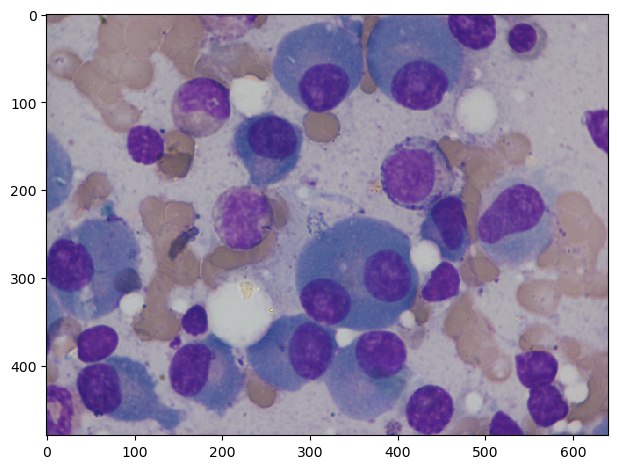

In [4]:
input_path = "./image/examples"

img1 = io.imread(f"{input_path}/img1.tiff") #
io.imshow(img1)

/tmp/ipykernel_24420/1079238842.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(img2)


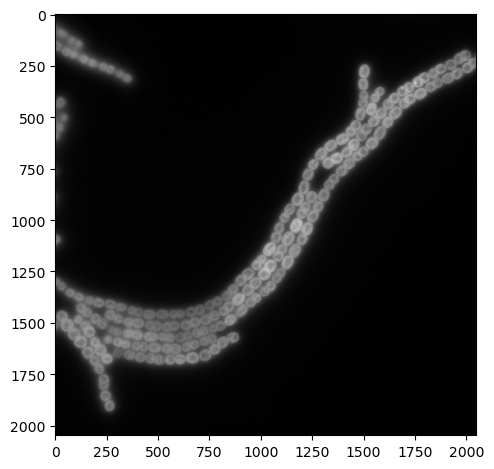

In [5]:
img2 = io.imread(f"{input_path}/img2.tif") #
io.imshow(img2)

# 새 섹션



---



### 4. Prediction - (1): Single Model

Let's detect the cell instances in the image using a single `MEDIARFormer` model.

- The `Predictor` conduct its pediction on all images in the `input_path` and save the results in the `output_path`.

- In this example, we do not use test-time Augmentation by setting `use_tta` as `False`.

In [6]:
output_path = "results"

predictor = Predictor(model1, "cuda:0", input_path, output_path, algo_params={"use_tta": False})
_ = predictor.conduct_prediction()


Prediction finished: img1.tiff; img size = torch.Size([1, 3, 480, 640]); costing: 0.43s
Prediction finished: img2.tif; img size = torch.Size([1, 3, 2048, 2048]); costing: 6.65s

 Total Time Cost: 7.08s


The results are as follows:


29 Cells detected!


/tmp/ipykernel_24420/4072276056.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(pred1, cmap="cividis")
/home/ggenois/anaconda3/envs/NeurIPS-CellSeg/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


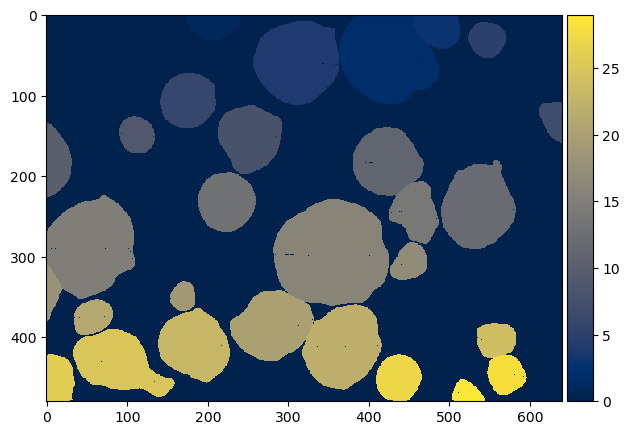

In [7]:
pred1 = io.imread(f"./{output_path}/img1_label.tiff")
io.imshow(pred1, cmap="cividis")

cell_count = len(np.unique(pred1))-1 # exclude the background
print(f"\n{cell_count} Cells detected!")


201 Cells detected!


/tmp/ipykernel_24420/435703593.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(pred2, cmap="cividis")
/home/ggenois/anaconda3/envs/NeurIPS-CellSeg/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


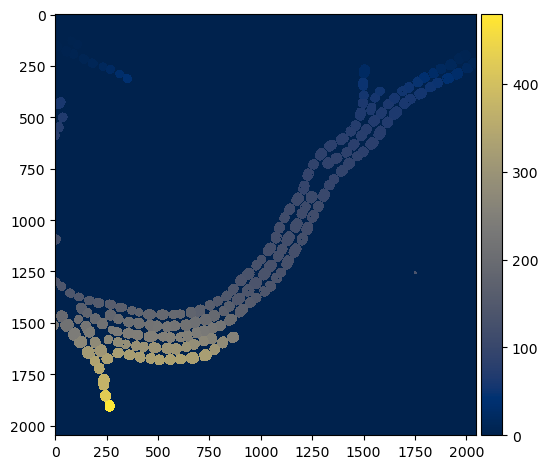

In [8]:
pred2 = io.imread(f"./{output_path}/img2_label.tiff")
io.imshow(pred2, cmap="cividis")

cell_count = len(np.unique(pred2))-1 # exclude the background
print(f"\n{cell_count} Cells detected!")



---



### 5. Prediction - (2): Ensemble Model + TTA

Let's use the ensemble models with TTA.

- In this example, we use test-time Augmentation by setting `use_tta` as `True`.

It takes much longer, as it need to conduct multiple forward paths.

In [9]:
predictor = EnsemblePredictor(model1, model2, "cuda:0", input_path, output_path, algo_params={"use_tta": True})
_ = predictor.conduct_prediction()

Prediction finished: img1.tiff; img size = torch.Size([1, 3, 480, 640]); costing: 1.14s
Prediction finished: img2.tif; img size = torch.Size([1, 3, 2048, 2048]); costing: 34.72s

 Total Time Cost: 35.86s



30 Cells detected!


/tmp/ipykernel_24420/4072276056.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(pred1, cmap="cividis")
/home/ggenois/anaconda3/envs/NeurIPS-CellSeg/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


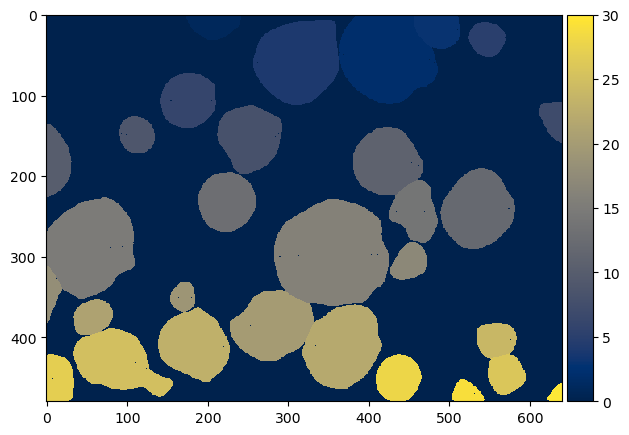

In [10]:
pred1 = io.imread(f"./{output_path}/img1_label.tiff")
io.imshow(pred1, cmap="cividis")

cell_count = len(np.unique(pred1))-1 # exclude the background
print(f"\n{cell_count} Cells detected!")


200 Cells detected!


/tmp/ipykernel_24420/435703593.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(pred2, cmap="cividis")
/home/ggenois/anaconda3/envs/NeurIPS-CellSeg/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


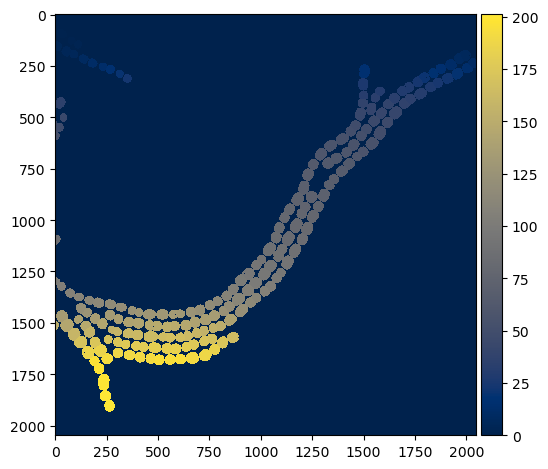

In [11]:
pred2 = io.imread(f"./{output_path}/img2_label.tiff")
io.imshow(pred2, cmap="cividis")

cell_count = len(np.unique(pred2))-1 # exclude the background
print(f"\n{cell_count} Cells detected!")



---